In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import QuantileTransformer
import scipy.stats as sci
import sklearn
sns.set_style("whitegrid")
sns.set_palette("deep")
#plt.style.use("seaborn-whitegrid")
from sklearn.model_selection import GridSearchCV
# import catboost as catb
# import lightgbm as lgb

from plot_mean_foehn_conditions import calculate_stability, plot_mean_foehn_condition_for_one_model, generate_coordinates_from_feature_label
from utils import calc_pot_temp
from model_training import *

# Define constants

In [57]:
LATS_CESM_STRING = ['4287', '4382', '4476', '4570', '4664', '4759', '4853', '4947']
LONS_CESM_STRING = ['0', '125', '250', '375', '500', '625', '750', '875', '1000', '1125', '1250', '1375', '1500']

MONTH_NAMES = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dez"]

# Read ERA data

In [60]:
df_ERA_raw = pd.read_csv("data/FoehnAndMeteorologicalData/ERAI_and_South_Foehn_Altdorf_data.csv.gz", parse_dates=["date"])

In [71]:
df_ERA = df_ERA_raw.copy()
df_ERA=df_ERA.dropna()
df_ERA=df_ERA.reset_index(drop=True)

# Calculate derived variables

In [72]:
# Create train and test mask
test_mask = (df_ERA["date"]>np.datetime64("1991-01-01 00:00")) & (df_ERA["date"]<np.datetime64("2000-12-31 23:00"))
train_mask = (test_mask == False)

In [73]:
def fit_RF_on_all_features(df, feature_names):
    
    model = RandomForestClassifier(n_estimators=1000, n_jobs=20, max_depth=7)
    
    # Fit model
    model.fit(df.loc[train_mask, feature_names], 
              df.loc[train_mask, "Foehn"])
    
    # Make predictions
    predictions = model.predict_proba(df.loc[test_mask, feature_names])
    
    # Calculate best threshold
    precisions, recalls, thresholds = precision_recall_curve(df.loc[test_mask, "Foehn"], predictions[:,1])
    best_threshold = thresholds[np.argmin(abs(precisions-recalls))]
    predictions = (predictions[:,1]>best_threshold).astype(int)
    
    # Plot precision and recall curves
    f = plt.figure(figsize=(12,5))
    f.add_subplot(121)
    sns.lineplot(precisions, recalls)
    f.add_subplot(122)
    sns.lineplot(np.append(thresholds, 1.0), precisions)
    sns.lineplot(np.append(thresholds, 1.0), recalls)
    
    # Print best threshold, precision, recall and confusion matrix
    print(f"Best threshold: {best_threshold}")
    print(f'Precision: {precision_score(df.loc[test_mask, "Foehn"], predictions)}')
    print(f'Recall: {recall_score(df.loc[test_mask, "Foehn"], predictions)}')
    print(confusion_matrix(df.loc[test_mask, "Foehn"], predictions))
        
    unordered_dict = dict(zip(feature_names, model.feature_importances_))
    return dict(sorted(unordered_dict.items(), key=lambda item: item[1], reverse=True)[0:30])


In [74]:
feature_importances_dict = dict()

Best threshold: 0.3443297469190944
Precision: 0.6814044213263979
Recall: 0.6805194805194805
[[13521   245]
 [  246   524]]


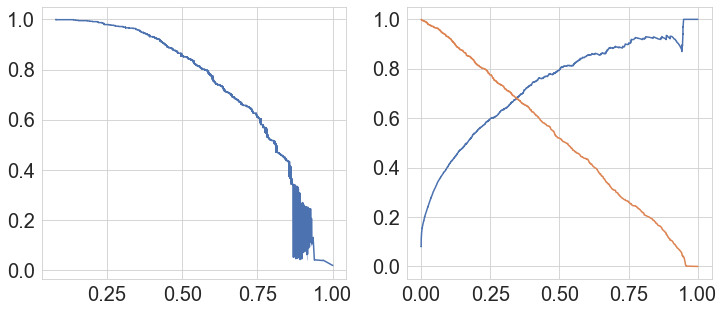

In [75]:
# Sealevel pressure differences
df_pressures = df_ERA.filter(regex=("SLP_\w+"))

pressure_list = sorted(df_pressures.columns.tolist())
pressure_list_dummy = sorted(df_pressures.columns.tolist())

SLP_dict = {}
for col1 in pressure_list:
    pressure_list_dummy.remove(col1)
    for col2 in pressure_list_dummy:
        SLP_dict[f"diff_{col1}_{col2}"] = (df_pressures.loc[:, col1] - df_pressures.loc[:, col2]).values

df = pd.DataFrame(SLP_dict)
df_pressures=df.copy()
feature_names = df.columns
df["Foehn"] = df_ERA["Foehn"]

feature_importances_dict.update(fit_RF_on_all_features(df, feature_names))


del SLP_dict

Best threshold: 0.40809629290652727
Precision: 0.6618985695708712
Recall: 0.6610389610389611
[[13506   260]
 [  261   509]]


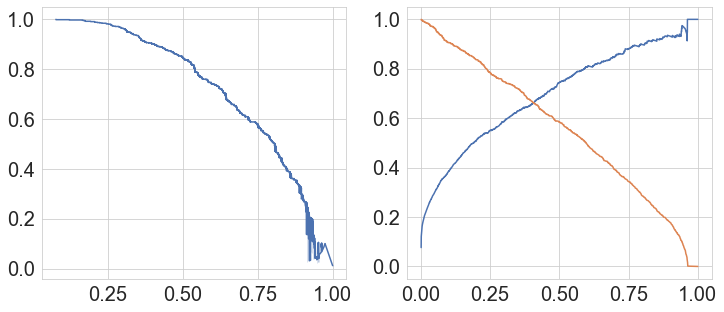

In [76]:
# Geopotential height (on 850 and 700 hPa)

df_Z = df_ERA.filter(regex=("Z_\w+"))
Z_dict = {}

for level in ["850", "700"]:
    df_Z_level = df_Z.filter(regex=("Z_\w+" + level))

    Z_list = sorted(df_Z_level.columns.tolist())
    Z_list_dummy = sorted(df_Z_level.columns.tolist())

    for col1 in Z_list:
        Z_list_dummy.remove(col1)
        for col2 in Z_list_dummy:
            Z_dict[f"diff_{col1}_{col2}"] = (df_Z_level.loc[:, col1] - df_Z_level.loc[:, col2]).values

df = pd.DataFrame(Z_dict)
df_Z=df.copy()
feature_names = df.columns
df["Foehn"] = df_ERA["Foehn"]

feature_importances_dict.update(fit_RF_on_all_features(df, feature_names))


del df_Z_level, Z_dict

Best threshold: 0.36371633970805367
Precision: 0.6618985695708712
Recall: 0.6610389610389611
[[13506   260]
 [  261   509]]


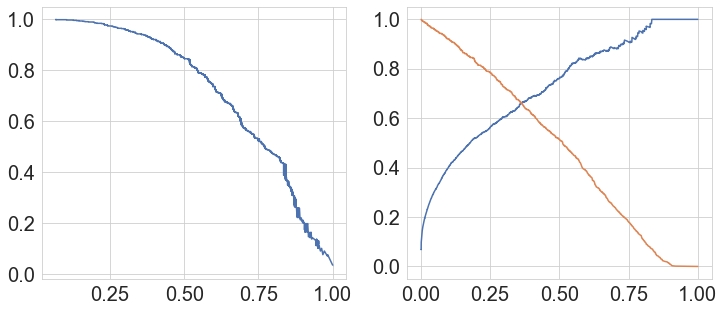

In [77]:
# Vertical potential temperature differences (on 850 hPa)

df_T = df_ERA.filter(regex=("T_\w+850"))
df_PHIT = calc_pot_temp(T=df_T+273.15, p=850.0).add_prefix("PHI")
PHIT_dict = {}

PHIT_list = sorted(df_PHIT.columns.tolist())
PHIT_list_dummy = sorted(df_PHIT.columns.tolist())

for col1 in PHIT_list:
    PHIT_list_dummy.remove(col1)
    for col2 in PHIT_list_dummy:
        PHIT_dict[f"diff_{col1}_{col2}"] = (df_PHIT.loc[:, col1] - df_PHIT.loc[:, col2]).values

df = pd.DataFrame(PHIT_dict)
df_PHIT =df.copy()
feature_names = df.columns
df["Foehn"] = df_ERA["Foehn"]

feature_importances_dict.update(fit_RF_on_all_features(df, feature_names))


del df_T, PHIT_dict

Best threshold: 0.19959178602202227
Precision: 0.5214564369310793
Recall: 0.5207792207792208
[[13398   368]
 [  369   401]]


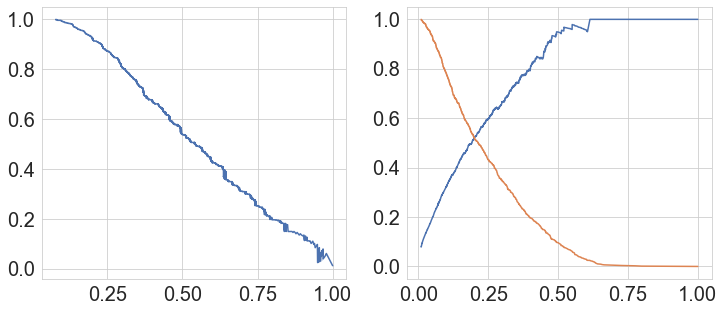

In [78]:
# Stability variables

df_T= df_ERA.filter(regex=("T\w+900")).add_prefix("PHI")
df_PHIT_900 = calc_pot_temp(T=df_T+273.15, p = 900.0)
df_T= df_ERA.filter(regex=("T\w+850")).add_prefix("PHI")
df_PHIT_850 = calc_pot_temp(T=df_T+273.15, p = 850.0)
df_T= df_ERA.filter(regex=("T\w+700")).add_prefix("PHI")
df_PHIT_700 = calc_pot_temp(T=df_T+273.15, p = 700.0)


stability_dict = {}
for lat in LATS_CESM_STRING:
    for lon in LONS_CESM_STRING:
        try:
            stability_dict[f"DELTAPHI_{lat}_{lon}_850"] = (df_PHIT_850.loc[:, f"PHIT_{lat}_{lon}_850"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
            stability_dict[f"DELTAPHI_{lat}_{lon}_700"] = (df_PHIT_700.loc[:, f"PHIT_{lat}_{lon}_700"] - df_PHIT_900.loc[:, f"PHIT_{lat}_{lon}_900"]).values
        except:
            print("Variable does not exist at this location.")

df = pd.DataFrame(stability_dict)
df_stability=df.copy()
feature_names = df.columns
df["Foehn"] = df_ERA["Foehn"]

feature_importances_dict.update(fit_RF_on_all_features(df, feature_names))


del df_T, df_PHIT_900, df_PHIT_850, df_PHIT_700, stability_dict

Best threshold: 0.3535065817901445
Precision: 0.6566970091027308
Recall: 0.6558441558441559
[[13502   264]
 [  265   505]]


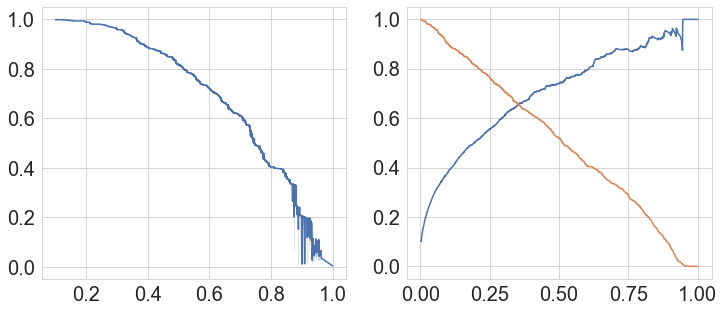

In [79]:
# Wind velocities
df = df_ERA.filter(regex=("(U|V)\w+")).copy()
df_wind=df.copy()
feature_names = df.columns
df["Foehn"] = df_ERA["Foehn"]

feature_importances_dict.update(fit_RF_on_all_features(df, feature_names))



In [80]:
df_ERA_all_features = pd.concat([df_ERA[["date", "Foehn"]], 
                     df_pressures, 
                     df_Z, 
                     df_PHIT, 
                     df_stability, 
                     df_wind], 
                    axis = 1)

# Fit XGBoost classifier on whole ERA data

In [81]:
feature_names=df_ERA_all_features.columns.tolist()
feature_names.remove("date")
feature_names.remove("Foehn")

Started
Best threshold: 0.9041125774383545
[[13599   167]
 [  167   603]]
Precision: 0.7831168831168831
Recall: 0.7831168831168831
ROC-AUC: 0.9905451224643438
Log-Loss: 0.0948582048043413


,feature_name,importance
0,diff_SLP_4570_875_sealevel_SLP_4759_875_sealevel,0.378369
1,diff_Z_4570_1125_850_Z_4570_750_850,0.074455
2,diff_PHIT_4382_375_850_PHIT_4759_875_850,0.056839
3,diff_SLP_4570_1125_sealevel_SLP_4759_875_sealevel,0.054509
4,diff_SLP_4570_1000_sealevel_SLP_4759_875_sealevel,0.019045
5,diff_Z_4570_1250_850_Z_4664_750_850,0.016886
6,diff_PHIT_4570_1125_850_PHIT_4759_1000_850,0.014491
7,diff_SLP_4664_1125_sealevel_SLP_4759_1000_seal...,0.013202
8,diff_Z_4664_1500_700_Z_4664_875_700,0.012968
9,diff_PHIT_4664_1000_850_PHIT_4759_1125_850,0.011810


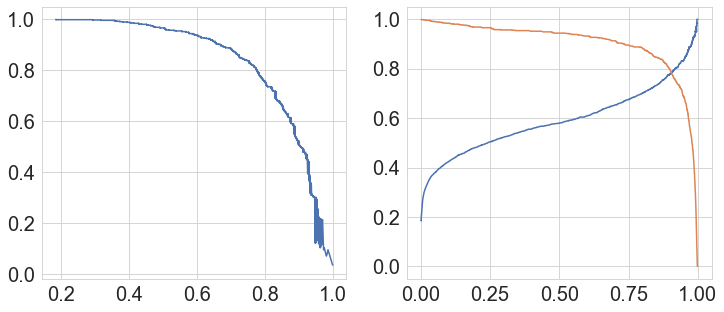

In [82]:
# Fit a global classifier on all features
model_xg = xgb.XGBClassifier(
                    max_depth=5,
                    learning_rate=0.1,
                    gamma=0.0,
                    min_child_weight=0.0,
                    max_delta_step=0.0,
                    subsample=1.0,
                    colsample_bytree=1.0,
                    colsample_bylevel=1.0,
                    reg_alpha=100.0,
                    reg_lambda=1.0,
                    n_estimators=300,
                    verbosity=0,
                    nthread=20,
                    scale_pos_weight=20.0,
                    base_score=0.05,
                    seed=1337,
                    missing=None,
                  )
params = {'max_depth': [2,3,4], 'learning_rate': [0.1, 0.2, 0.3], "reg_alpha": [0,10], "reg_lambda":[10,100]}
params = {'max_depth': [5], 'learning_rate': [0.2], "reg_alpha": [1], "reg_lambda":[100]}

df_ERA_feature_importances = fit_model_on_all_ERA_features_and_return_most_important_features(model_xg, params, df_ERA_all_features, feature_names, train_mask, test_mask, with_CV=True)

In [83]:
for i in range(10):
    string = df_ERA_feature_importances.loc[i, "feature_name"].split("_")
    try:
        print(f"$\Delta {string[1]}$ & {int(string[2])/100}, {int(string[3])/100} - {int(string[6])/100}, {int(string[7])/100} & {string[4]} hPa & {str(df_ERA_feature_importances.loc[i, 'importance'])[0:6]} \\") 
    except:
        print(f"$\Delta {string[1]}$ & {int(string[2])/100}, {int(string[3])/100} - {int(string[6])/100}, {int(string[7])/100} & {string[4]} hPa & {str(df_ERA_feature_importances.loc[i, 'importance'])[0:6]} \\") 
    

$\Delta SLP$ & 45.7, 8.75 - 47.59, 8.75 & sealevel hPa & 0.3783 \
$\Delta Z$ & 45.7, 11.25 - 45.7, 7.5 & 850 hPa & 0.0744 \
$\Delta PHIT$ & 43.82, 3.75 - 47.59, 8.75 & 850 hPa & 0.0568 \
$\Delta SLP$ & 45.7, 11.25 - 47.59, 8.75 & sealevel hPa & 0.0545 \
$\Delta SLP$ & 45.7, 10.0 - 47.59, 8.75 & sealevel hPa & 0.0190 \
$\Delta Z$ & 45.7, 12.5 - 46.64, 7.5 & 850 hPa & 0.0168 \
$\Delta PHIT$ & 45.7, 11.25 - 47.59, 10.0 & 850 hPa & 0.0144 \
$\Delta SLP$ & 46.64, 11.25 - 47.59, 10.0 & sealevel hPa & 0.0132 \
$\Delta Z$ & 46.64, 15.0 - 46.64, 8.75 & 700 hPa & 0.0129 \
$\Delta PHIT$ & 46.64, 10.0 - 47.59, 11.25 & 850 hPa & 0.0118 \


# Plot weathermaps

In [67]:
df_ERA_raw_temp_adjusted = df_ERA_raw.copy()

temp_columns = df_ERA_raw_temp_adjusted.filter(regex="T_").columns
df_ERA_raw_temp_adjusted[temp_columns] = df_ERA_raw_temp_adjusted[temp_columns]+ 273.15
df_ERA_with_stability = calculate_stability(df = df_ERA_raw_temp_adjusted, lats = LATS_CESM_STRING, lons = LONS_CESM_STRING)

#df_ERA_with_stability = pd.merge(df_foehn_raw, df_ERA_with_stability, on="date", how="inner")

In [84]:
variable ='DELTAPHI'

variable_lvl = {"SLP": "sealevel",
                "Z": "850",
                "T": "850",
                "DELTAPHI": "700",
                "U": "700",
                "V": "700"}

unit = {"SLP": "hPa",
        "Z": "meters",
        "T": "K",
        "DELTAPHI": "K",
        "U": "m/s",
        "V": "m/s"}


# # Altdorf
v_limits = {"SLP": [1003, 1022],
            "Z": [1360, 1570],
            "T": [3+273, 10.5+273],
            "DELTAPHI": [5,12],
            "U":[5,15],
            "V":[5,15]}

# # Piotta
# v_limits = {"SLP": [1013, 1025],#[1003, 1018],
#             "Z": [1460, 1530],#[1350, 1520],
#             "T": [-1+273.15, 6+273.15],
#             "DELTAPHI": [5.5, 12.5], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}

# Lugano
# v_limits = {"SLP": [1009, 1027.5],#[1003, 1018],
#             "Z": [1420, 1581],#[1350, 1520],
#             "T": [-3+273, 7.05+273],
#             "DELTAPHI": [4, 14.05], #[6,11],
#             "U":[5,15],
#             "V":[5,15]}



#df_importances["importance"] = df_importances["importance"]

In [85]:
feature_importances_dict

{'diff_SLP_4664_1125_sealevel_SLP_4759_875_sealevel': 0.012721901230556231,
 'diff_SLP_4570_1000_sealevel_SLP_4664_625_sealevel': 0.011072119581183875,
 'diff_SLP_4664_1125_sealevel_SLP_4759_1000_sealevel': 0.010013098638389057,
 'diff_SLP_4664_1250_sealevel_SLP_4759_875_sealevel': 0.009721882293751927,
 'diff_SLP_4570_1000_sealevel_SLP_4759_750_sealevel': 0.00912854202888774,
 'diff_SLP_4570_1125_sealevel_SLP_4759_875_sealevel': 0.008882610382560403,
 'diff_SLP_4476_750_sealevel_SLP_4664_750_sealevel': 0.008874665447189099,
 'diff_SLP_4570_1000_sealevel_SLP_4664_750_sealevel': 0.00867549639464374,
 'diff_SLP_4570_1125_sealevel_SLP_4664_625_sealevel': 0.008608968404746195,
 'diff_SLP_4570_1000_sealevel_SLP_4759_875_sealevel': 0.008471452234897254,
 'diff_SLP_4570_750_sealevel_SLP_4664_750_sealevel': 0.008312647304169647,
 'diff_SLP_4664_1000_sealevel_SLP_4759_875_sealevel': 0.00825332655427489,
 'diff_SLP_4570_1125_sealevel_SLP_4759_750_sealevel': 0.008220260236081895,
 'diff_SLP_4570_

Saved figure at: /home/chmony/Documents/Results/newgradient/weathermap_T_850_OBS_SouthFoehn.pdf'


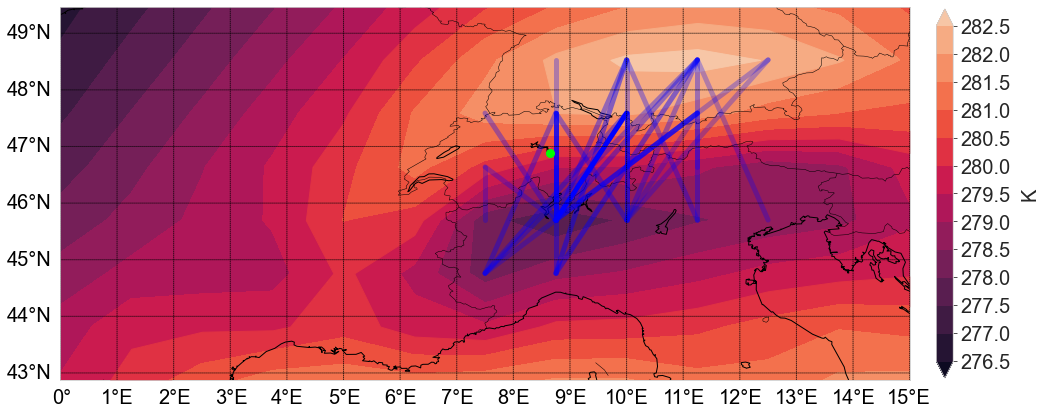

In [88]:
for variable in list(variable_lvl.keys())[2:3]:
    kwargs = {"variable": variable,
          "variable_lvl": variable_lvl[variable],
          "unit": unit[variable],
          "vmin": v_limits[variable][0],
          "vmax": v_limits[variable][1],
          "lats_labels": LATS_CESM_STRING, 
          "lons_labels": LONS_CESM_STRING,
          "df_importances": generate_coordinates_from_feature_label(feature_importances_dict, variable)}
    plot_mean_foehn_condition_for_one_model(**kwargs, 
                                            model= f"OBS_SouthFoehn", 
                                            df = df_ERA_with_stability, 
                                            foehn = df_ERA_with_stability["Foehn"], 
                                            )
